In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import scipy
%matplotlib inline
import math
import random

### Read in data

In [2]:
X = pd.read_csv("data/hw2-data/X.csv", header = None)
y = pd.read_csv("data/hw2-data/y.csv", header = None)

In [3]:
skf = StratifiedKFold(n_splits=10, shuffle = True)
skf.get_n_splits(X, y)

10

In [4]:
def get_pi(y): 
    return(y.sum()/len(y))

In [5]:
def get_lambdas(X,y):
    lambda_arr0 = []
    lambda_arr1 = []
    alpha = 2
    beta = 1 
    X_1 = X[y[0]==1]
    X_0 = X[y[0]==0]
    n_1 = len(X_1)
    n_0 = len(X_0)
    for idx,col in enumerate(X):
        lambda_0 = (alpha - 1 + sum(X_0[idx]))/(n_0+beta)
        lambda_1 = (alpha - 1 + sum(X_1[idx]))/(n_1+beta)
        lambda_arr0.append(lambda_0)
        lambda_arr1.append(lambda_1)
    return lambda_arr0, lambda_arr1

In [6]:
def get_prob_like(row,lambdas_0,lambdas_1,pi):
    for idx,dim in enumerate(row):
        l0 = lambdas_0[idx]
        l1 = lambdas_1[idx]
        if idx==0:
            joint_like = scipy.stats.distributions.poisson.pmf(dim,l0)
            joint_like_1 = scipy.stats.distributions.poisson.pmf(dim,l1)
        else:
            joint_like =  joint_like*scipy.stats.distributions.poisson.pmf(dim, l0)
            joint_like_1 =  joint_like_1*scipy.stats.distributions.poisson.pmf(dim, l1)
    return(joint_like*pi , joint_like_1*(1-pi)) 

p(y|x) = p(x|y=1)p(y=1) > p(x|y=0)p(y=0)

In [7]:
preds = []
actuals = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    pi = get_pi(y_train)
    l0,l1 = get_lambdas(X_train,y_train)
    for idx, row in X_test.iterrows():
        p0,p1=get_prob_like(row,l0,l1,pi)
        if (p0.values>p1.values):
            out = 0
        else:
            out = 1
        preds.append(out)
        actuals.append(y_test.loc[idx].values[0])

In [8]:
matrix = np.zeros((2,2))
for a,b in zip(actuals,preds):
    if (a==0) & (b==0):
        matrix[0,0]+=1
    if (a==0) & (b==1):
        matrix[0,1] +=1 
    if (a==1) & (b==0):
        matrix[1,0] +=1
    if (a==1) & (b==1):
        matrix[1,1] +=1

In [9]:
y[0].value_counts()

0    2787
1    1813
Name: 0, dtype: int64

In [10]:
matrix[0,0], matrix[0,1], matrix[1,0], matrix[1,1]

(2242.0, 545.0, 99.0, 1714.0)

In [11]:
(matrix[0,0] + matrix[1,1]) / len(X)

0.85999999999999999

In [12]:
l_averages_out = dict()
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    l0,l1 = get_lambdas(X_train,y_train)
    for i,(a,b) in enumerate(zip(l0,l1)):
        if i not in l_averages_out:
            l_averages_out[i] = [a,b]
        l_averages_out[i][0] += a
        l_averages_out[i][1] += b 

In [13]:
l0_arr=[]
l1_arr=[]
for i in range(len(X.columns)):
    vals = l_averages_out[i]
    l0_arr.append(vals[0]/10)
    l1_arr.append(vals[1]/10)

Text(0.5,0,'Dimensions')

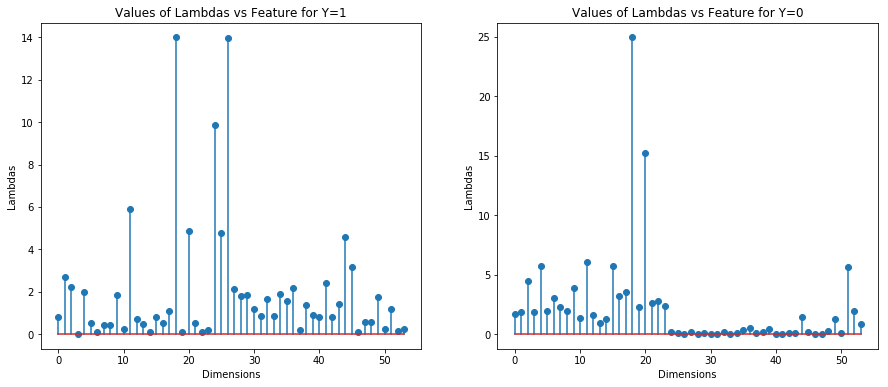

In [14]:
f = plt.figure(figsize=(15,6))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.stem(l0_arr)
ax.set_title("Values of Lambdas vs Feature for Y=1")
ax.set_ylabel("Lambdas")
ax.set_xlabel("Dimensions")
ax2.stem(l1_arr)
ax2.set_title("Values of Lambdas vs Feature for Y=0")
ax2.set_ylabel("Lambdas")
ax2.set_xlabel("Dimensions")

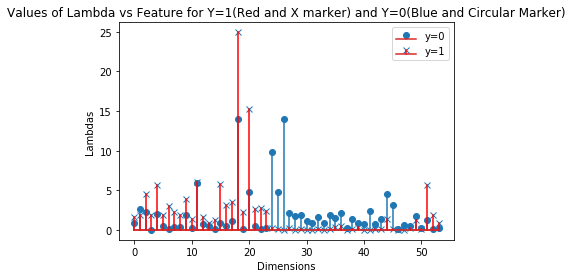

In [27]:
plt.stem(l0_arr)
plt.stem(l1_arr,'r','x')
plt.title('Values of Lambda vs Feature for Y=1(Red and X marker) and Y=0(Blue and Circular Marker)')
plt.xlabel('Dimensions')
plt.ylabel('Lambdas')
plt.legend(['y=0','y=1'])

In [18]:
l0_arr[15],l0_arr[51]

(0.81250816582216367, 1.2048878221668926)

In [19]:
l1_arr[15], l1_arr[51]

(5.7352675891238309, 5.6484199956773891)

In [22]:
l1_arr[18], l1_arr[18]

(24.961516155758073, 24.961516155758073)

### 2b)

Though they don't have the highest lambdas, dimensions 16 and 52 still have very high lambdas given y=1, but low lambdas given y=0. These dimensions correspond to the word free and an exclamation mark, !. Intuitively, from our experiences, these words tend to occur a lot more in spam emails, so our data corroborates that. There is a strong reason to believe that these two features are very predictive in identifying spams.

To understand what these lambdas mean, we need to understand our assumptions on distribution of X. We are modeling the count or frequencies of words of our features using a poisson distribution (assignment is not clear on this so I'm assuming the numeric values mean word frequencies). So higher conditional lambdas mean that we are observing on average, more occurences of these features in spam emails as opposed to nonspam emails.

We should also point out that the poisson distribution is conditional on y. So we have two separate lambdas per feature based on whether we condition on y=1, spam emails or y=0, no-spam emails. So the differences between the two is significant because it gives as un inference when we are looking at the posterior that should you observe more frequencies of these features, it's more likely the email is a spam as opposed to a non-spam.


## 2c)

In [50]:
def distances(X_train,X_test):
    dists = np.zeros((X_test.shape[0],X_train.shape[0]))
    for i in range(X_train.shape[0]):
        l1_dist = (np.abs(X_test-X_train.T.iloc[:,i])).sum(axis=1)
        dists[:,i] = l1_dist
    return dists

In [53]:
def knn_predict(dists,y_train,y_test):
    predictions_fin = []
    for k in range(20):
        predictions =[]
        for i in range(dists.shape[0]):
            pred = 0 
            indices = dists[i,:].argsort()[:k]
            for j in indices: 
                pred += y_train.iloc[j][0]
            if pred > k/2:
                predictions.append(1)
            elif pred == k/2:
                ###break-tie with nearest one
                nearest_one = dists[i,:].argsort()[:1]
                pred = y_train.iloc[dists[i,:].argsort()[:1][0]][0]
                predictions.append(pred)
            else: 
                predictions.append(0)
        accuracy = (y_test.reset_index(drop=True)[0]==pd.Series(predictions)).sum()/len(y_test)
        predictions_fin.append(accuracy)
    return predictions_fin

In [54]:
out = dict()
for idx,(train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dists = distances(X_train,X_test)
    predictions_fin = knn_predict(dists,y_train,y_test)
    out[idx] = predictions_fin

In [55]:
accuracies_final = np.zeros(20)
for fold, accuracies in out.items():
    for k in range(20):
        accuracies_final[k] = accuracies_final[k]+accuracies[k]

In [56]:
accuracies_final = accuracies_final/10

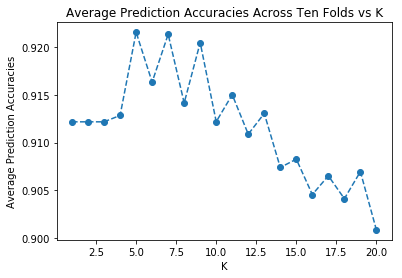

In [66]:
plt.title('Average Prediction Accuracies Across Ten Folds vs K')
plt.xlabel('K')
plt.ylabel('Average Prediction Accuracies')
xi = [i for i in range(1, len(accuracies_final)+1)]
plt.plot(xi, accuracies_final, marker='o', linestyle='--', label='Square') 

## 2d)

In [69]:
y_logit = y.copy()

In [70]:
y_logit[y_logit[0]==0] = -1 

In [71]:
X_logit = X.copy()

In [72]:
X_logit['54'] = 1

In [73]:
step_size = .01/4600

In [78]:
def sigmoid_fnc(X,y,w):
    return np.exp(np.dot(X.mul(y[0],axis=0),w))/(1+np.exp(np.dot(X.mul(y[0],axis=0),w)))

In [79]:
def calc_logistic(X_logit,y_logit):
    wo = np.zeros(len(X_logit.columns))
    wt = wo
    out = []
    for i in range(1000):
        likelihood = sigmoid_fnc(X_logit,y_logit,wt)
        sum_=np.matmul((1-likelihood)*y_logit[0],X_logit)
        out.append(np.sum(np.log(likelihood)))
        wt += step_size*sum_
    return wt,out

In [80]:
out_logit = dict()
for idx,(train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X_logit.iloc[train_index], X_logit.iloc[test_index]
    y_train, y_test = y_logit.iloc[train_index], y_logit.iloc[test_index]
    fold_i_wt, fold_i_ll = calc_logistic(X_train,y_train)
    out_logit[idx] = fold_i_ll

Text(0,0.5,'Likelihood')

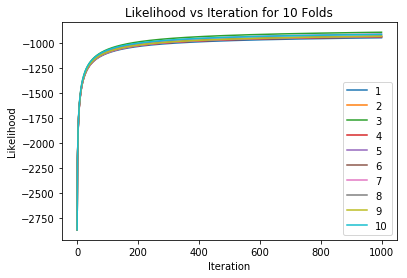

In [127]:
for key,val in out_logit.items():
    plt.plot(val)
plt.legend(range(1,11))
plt.title("Likelihood vs Iteration for 10 Folds")
plt.xlabel("Iteration")
plt.ylabel("Likelihood")

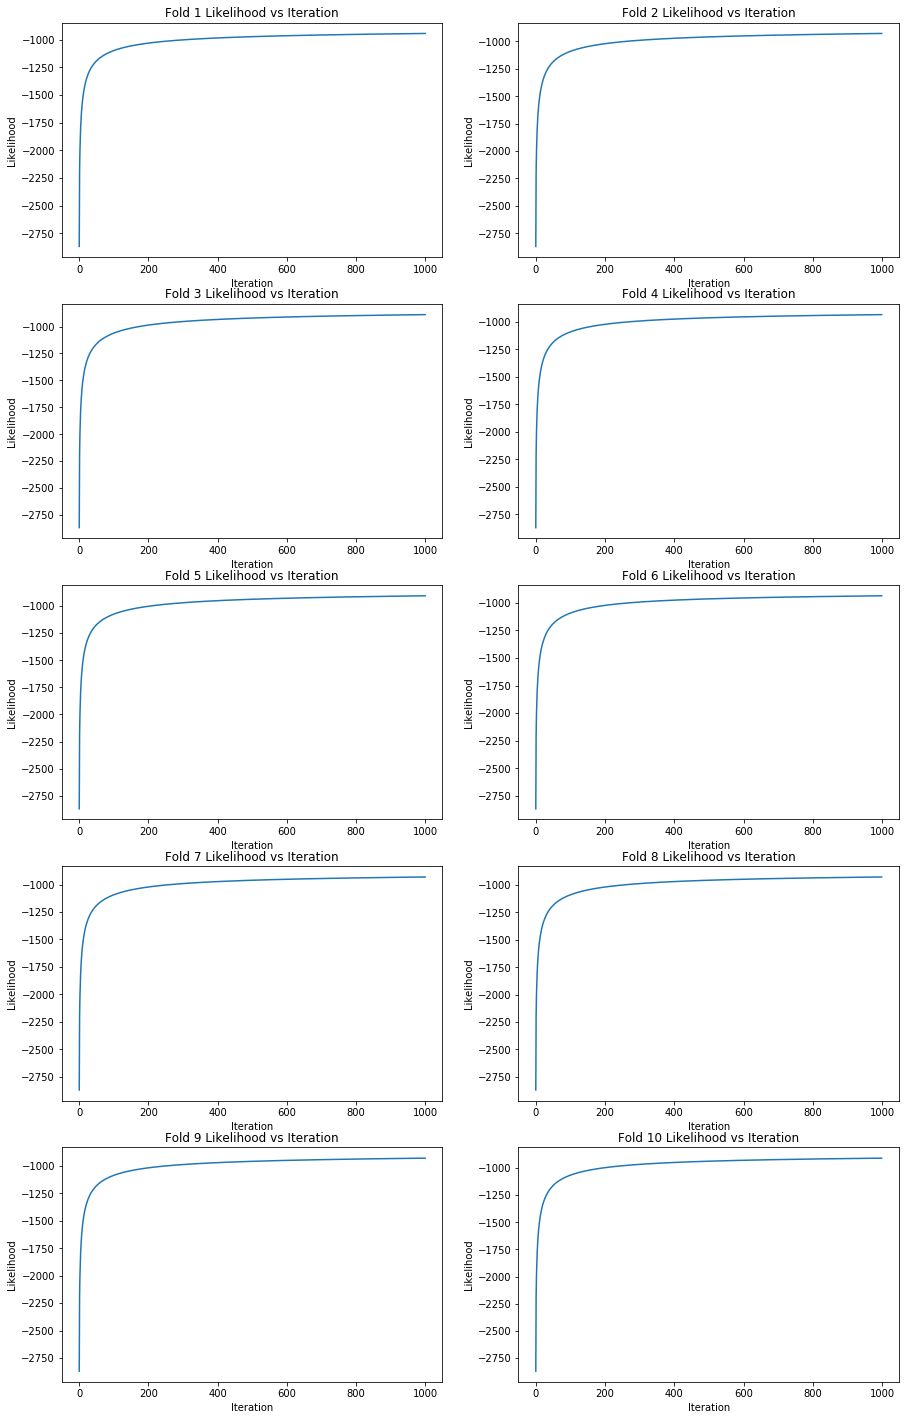

In [117]:
f = plt.figure(figsize=(15,25))
for idx,(key,val) in enumerate(out_logit.items()):
    if idx<9:
        tmp = f.add_subplot('52'+str(idx+1))
    else: 
        tmp=f.add_subplot('520')
    tmp.plot(val)
    tmp.set_title("Fold "  + str(idx+1) + " Likelihood vs Iteration")
    tmp.set_xlabel("Iteration" )
    tmp.set_ylabel("Likelihood" )

## 2e)

In [166]:
out_logit = dict()
matrix = np.zeros((2,2))    
for idx,(train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X_logit.iloc[train_index], X_logit.iloc[test_index]
    y_train, y_test = y_logit.iloc[train_index], y_logit.iloc[test_index]
    
    w = np.zeros(len(X_train.columns))   
    loglike = []
    for i in range(100):
        likelihood = sigmoid_fnc(X_train,y_train,w)
        delta_L = np.dot((1-likelihood)*y_train[0],X_train)
        D = np.diag(likelihood*(1-likelihood)+.000001)
        hessian = -1 *np.matmul(np.matmul(X_train.T,D),X_train)
        w -= np.matmul(np.linalg.inv(hessian),delta_L)
        loglike.append(np.sum(np.log(likelihood)))
    out_logit[idx]= loglike 
    y_pred = X_test.mul(w).apply(sum,axis=1)
    y_pred_sign = np.sign(y_pred)
    y_pred_sign.index = range(len(y_test))    
    for i in range(len(y_test[0])):
        if(y_pred_sign[i]==-1):
            if y_test.iloc[i,0]==1:
                matrix[1,0] += 1
            else:
                matrix[0,0] +=1
        else:
            if y_test.iloc[i,0]==-1:
                matrix[0,1] += 1
            else:
                matrix[1,1] +=1
    

Text(0,0.5,'Likelihood')

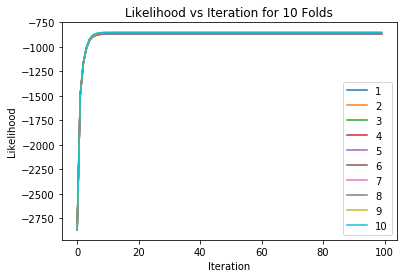

In [167]:
for key,val in out_logit.items():
    plt.plot(val)
plt.legend(range(1,11))
plt.title("Likelihood vs Iteration for 10 Folds")
plt.xlabel("Iteration")
plt.ylabel("Likelihood")

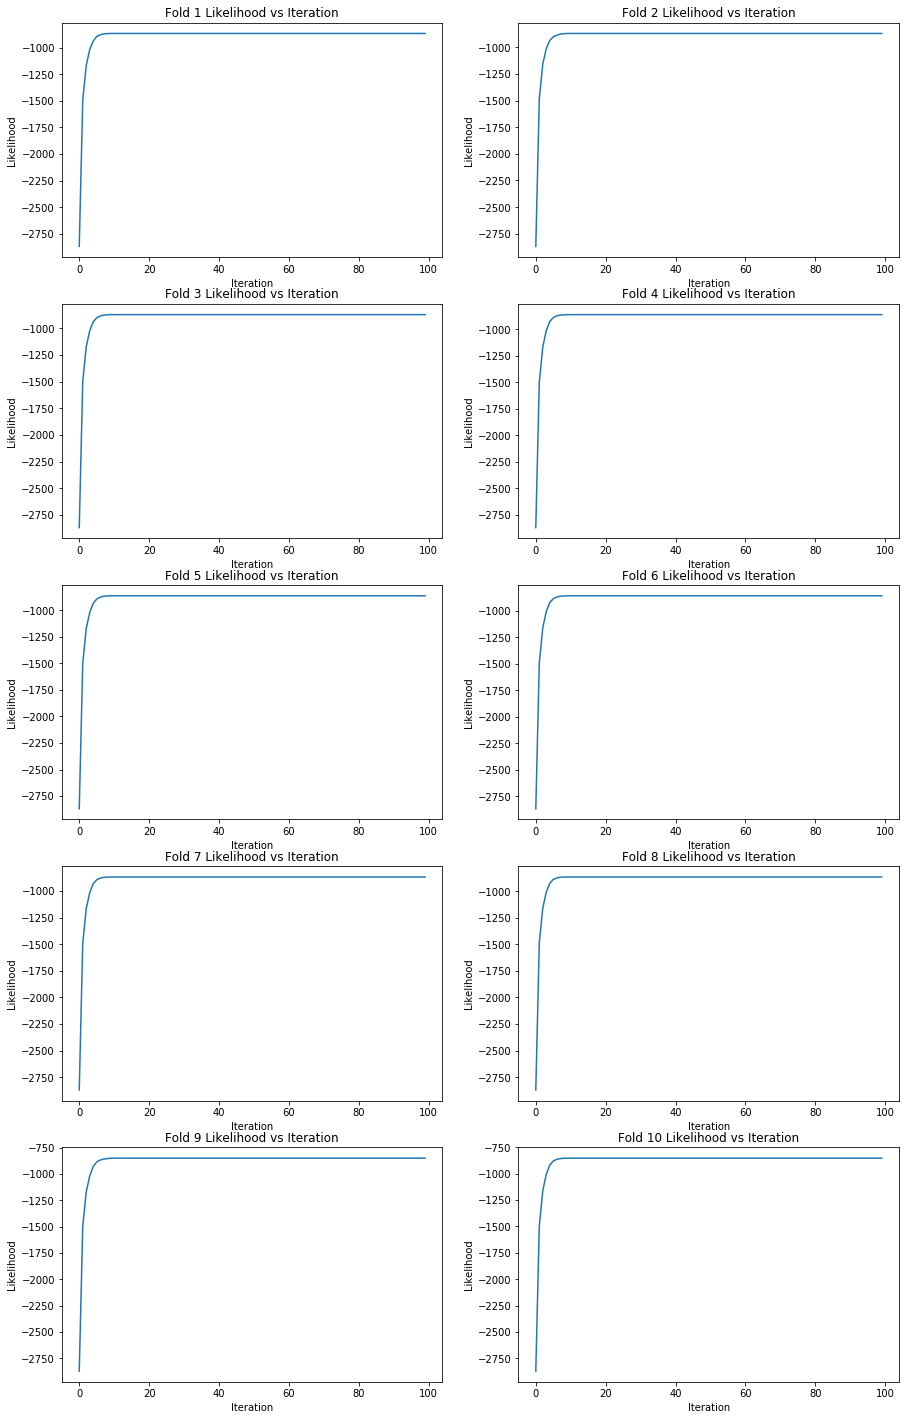

In [168]:
f = plt.figure(figsize=(15,25))
for idx,(key,val) in enumerate(out_logit.items()):
    if idx<9:
        tmp = f.add_subplot('52'+str(idx+1))
    else: 
        tmp=f.add_subplot('520')
    tmp.plot(val)
    tmp.set_title("Fold "  + str(idx+1) + " Likelihood vs Iteration")
    tmp.set_xlabel("Iteration" )
    tmp.set_ylabel("Likelihood" )

In [169]:
matrix

array([[ 2646.,   141.],
       [  219.,  1594.]])

In [158]:
(matrix[0,0] + matrix[1,1]) / len(X)

0.92260869565217396